# TASKS:
1) Conduct and EDA on athletes.csv
2) Handle nan values however you like
3) Train any model on the dataset
4) Look at the ROC-AUC and PR-curve metrics
5) Try to build your own ROC and PR curves

In [1]:
import pandas as pd
import numpy as np

In [2]:
def see_df_stats(data):
    print(f'{"column name":^12} | {"unique":^10} | missing')
    print('-'*36)

    for i in data.columns:
        print(f'{i:^12} | {data[i].nunique():^10} | {sum(data[i].isna()):^10}')

In [3]:
backup = pd.read_csv('Data/athletes.csv')

In [4]:
df = backup.copy()

# EDA

- Categorical - nationality, sex, sport, gold, silver, bronze

- Numeric - dob, height, weight

- Meaningless - id, name 

In [5]:
df.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [7]:
see_df_stats(df)

column name  |   unique   | missing
------------------------------------
     id      |   11538    |     0     
    name     |   11517    |     0     
nationality  |    207     |     0     
    sex      |     2      |     0     
    dob      |    5595    |     1     
   height    |     82     |    330    
   weight    |    123     |    659    
   sport     |     28     |     0     
    gold     |     6      |     0     
   silver    |     3      |     0     
   bronze    |     3      |     0     


# Data handling

### Translating dob into 'age'

In [8]:
from datetime import datetime

df.loc[df['dob'].isnull(), 'dob'] = '12/25/87' # Date of Birth of Pavel Sozykin

olympics_date = datetime(2016, 8, 21)
y_o = lambda dob: int((olympics_date - datetime.strptime(dob, '%m/%d/%y')).days // 366)

df['dob'] = [y_o(dob) for dob in df['dob']]
df = df.rename({'dob':'age'}, axis=1)

### Handling height & weight with a simple mean inserting

In [9]:
for i in df['age'].unique():
    df.loc[(df['age']==i) & (df['weight'].isna()), 'weight'] = df.loc[df['age'] == i, 'weight'].mean()
    df.loc[(df['age']==i) & (df['height'].isna()), 'height'] = df.loc[df['age'] == i, 'height'].mean()

In [10]:
see_df_stats(df)

column name  |   unique   | missing
------------------------------------
     id      |   11538    |     0     
    name     |   11517    |     0     
nationality  |    207     |     0     
    sex      |     2      |     0     
    age      |     50     |     0     
   height    |    109     |     0     
   weight    |    152     |     0     
   sport     |     28     |     0     
    gold     |     6      |     0     
   silver    |     3      |     0     
   bronze    |     3      |     0     


# Prediction

In [11]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

## With scaling and dummies

- Encoding categorical values

In [12]:
enc = LabelEncoder()

for i in ('nationality', 'sex', 'sport', 'gold', 'silver', 'bronze'):
    df[i] = enc.fit_transform(df[i])

- Scaling numerical values from 0 to 1

In [13]:
scl = MinMaxScaler()
model = LogisticRegression(random_state=15, max_iter=1000)

df[['height', 'age', 'weight']] = scl.fit_transform(df[['height', 'age', 'weight']])

- Separating X and y values, splitting into train and test

In [14]:
X_data = ('nationality', 'sport', 'gold', 'silver', 'bronze', 'height', 'weight')

X = pd.get_dummies(df.drop(columns=['id', 'sex', 'name'], axis=1), columns=[i for i in X_data if not 'ght' in i])
y = np.array(df['sex'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

- Launching model, getting predicted values and probabilities

In [15]:
model.fit(X_train, y_train)

yhat = model.predict(X_test)
yproba = model.predict_proba(X_test)

- Computing results and metrics

In [16]:
model.score(X_test, y_test)

0.8246678220681687

- All the same for different model (predicting sex only by numeric values)

In [17]:
X1 = df[['height', 'age', 'weight']]
y1 = np.array(df['sex'])

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y1, test_size=0.2, random_state=5)

In [18]:
model.fit(X_train_1, y_train_1)

yhat1 = model.predict(X_test_1)
yproba1 = model.predict_proba(X_test_1)

In [19]:
model.score(X_test_1, y_test_1)

0.7603986135181976

- Calculating FPR, TPR metrics
- Building a plot

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, yproba[:, 1])

In [21]:
fpr1, tpr1, thresholds1 = roc_curve(y_test_1, yproba1[:, 1])

In [22]:
import matplotlib.pyplot as plt

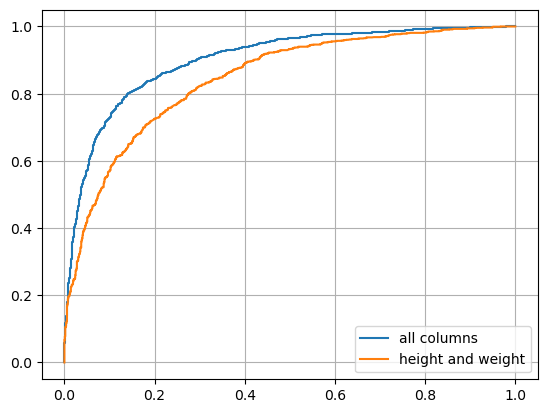

In [23]:
plt.plot(fpr, tpr, label='all columns')
plt.plot(fpr1, tpr1, label='height and weight')
plt.grid()
plt.legend()

In [24]:
roc_auc = roc_auc_score(y_test, yproba[:, 1])
roc_auc1 = roc_auc_score(y_test_1, yproba1[:, 1])

print(f'ROC AUC score for all columns: {roc_auc}\n')
print(f'ROC AUC score only on numeric cols: {roc_auc1}')

ROC AUC score for all columns: 0.9012381536343197

ROC AUC score only on numeric cols: 0.8453587001405478


# My own cruves with blackjack and defs

### ROC-AUC

In [25]:
d = sorted({i : n for i, n in zip(yproba1[:,1], y_test_1)}.items(), reverse=True)

In [26]:
def f(test, proba, thresh=0.5, f='roc'):
    
    tp, fp, tn, fn = [0 for _ in range(4)]
    
    for actual, prob in zip(test, proba):
        pred = 1 if prob >= thresh else 0
        if pred == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1
        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    if f =='roc':
        return fpr, tpr
    elif f == 'PR':
        return prec, recall

In [27]:
def roc():
    n = d[0][1]

    FPRs = []
    TPRs = []

    for i in range(len(d)):
        if i == 0:
            FPRs.append(0)
            TPRs.append(0)
        elif i == len(d)-1:
            FPRs.append(1)
            TPRs.append(1)

        if d[i][1] != n:
            FPRs.append(f(y_test_1, yproba1[:,1], thresh=d[i-1][0])[0])
            TPRs.append(f(y_test_1, yproba1[:,1], thresh=d[i-1][0])[1])
            if n == 0:
                n += 1
            elif n ==1:
                n -= 1
    return FPRs, TPRs

In [28]:
FPRs, TPRs = roc()

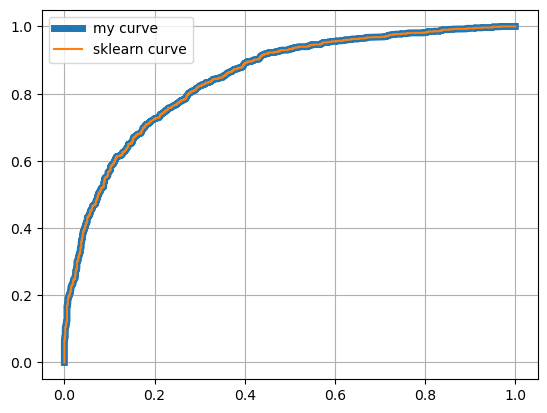

In [29]:
plt.plot(FPRs, TPRs, linewidth=5, label='my curve')
plt.plot(fpr1, tpr1, label='sklearn curve')
plt.grid()
plt.legend()

### PR-curve

In [30]:
prec, recall, threshholds = precision_recall_curve(y_test_1, yproba1[:, 1])

In [31]:
def PR_curve():
    prec = []
    recall = []

    for i in range(len(d)):
        prec.append(f(y_test_1, yproba1[:,1], thresh=d[i][0], f='PR')[0])
        recall.append(f(y_test_1, yproba1[:,1], thresh=d[i][0], f='PR')[1])
                
    return prec, recall

In [32]:
my_prec, my_recall = PR_curve()

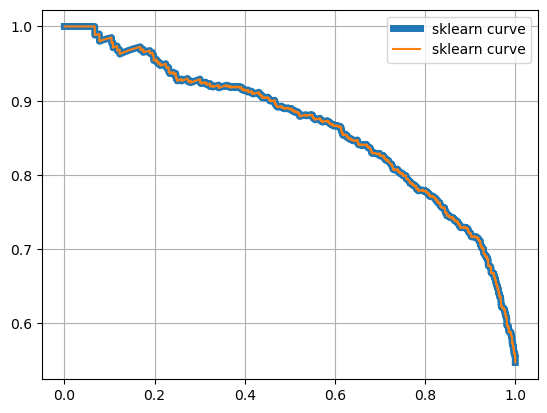

In [33]:
plt.plot(recall, prec, linewidth=5, label='sklearn curve')
plt.plot(my_recall, my_prec, label='sklearn curve')
plt.grid()
plt.legend()